<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [4]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from os.path import basename, splitext
import re
import math
import more_itertools as mit
from datetime import datetime, date

In [5]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/home/kris/Документы/user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [6]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path,
                                    session_length=10, window_size=10):
    
    csv_files = glob(path_to_csv_files + '/*.csv')
    csv_files.sort()
    all_sites = []
    timestamp = []
    all_time_delta_session = []
    start_session = []
    day_of_week = []
    uniq_values = []
    
    #открытие уже ранее созданного частотного словаря    
    with open(site_freq_path, 'rb') as fp:
        frequency_dict = pickle.load(fp)
        
    #добавление сайтов и даты их посещения в списки
    for file in tqdm_notebook(csv_files):
        data = pd.read_csv(file, engine = 'python')
        all_sites.append(data['site'])
        timestamp.append(data['timestamp'])

        #подсчет продолжительности сессии, начала сессии и дня недели  
        time_session = pd.to_datetime(data['timestamp'])
        for i in range(0, len(time_session), session_length):
            if (i + session_length) < len(time_session):
                time_delta_session = datetime.strptime(str(time_session[i + session_length - 1]), '%Y-%m-%d %H:%M:%S') - datetime.strptime(str(time_session[i]), '%Y-%m-%d %H:%M:%S')
                all_time_delta_session.append(time_delta_session.seconds)
                start_session.append(datetime.strptime(str(time_session[i]), '%Y-%m-%d %H:%M:%S').hour)
                day_of_week.append(time_session.dt.dayofweek[i]) 
            else:
                time_delta_session = datetime.strptime(str(max(time_session)), '%Y-%m-%d %H:%M:%S')- datetime.strptime(str(time_session[i]), '%Y-%m-%d %H:%M:%S')
                all_time_delta_session.append(time_delta_session.seconds)
                start_session.append(datetime.strptime(str(time_session[i]), '%Y-%m-%d %H:%M:%S').hour)
                day_of_week.append(time_session.dt.dayofweek[i]) 


    #создание списка с id пользователей 
    user_id = []
    for i in csv_files:
        file_name, _ = splitext(basename(i))
        file_name = re.sub('^0*', '', file_name[4:])
        user_id.append(int(file_name))   

    columns_sites = ['site' + str(i) for i in range(1, session_length + 1)]
    columns_times = ['diff_time' + str(i) for i in range(1, session_length + 1)]

    features_sites = []
    features_times = []
    
    #формирование сессий по каждому пользователю в зависимости от длины сессии(session_length) и ширины окна(window_size)
    for index, (times, sites) in enumerate(zip(timestamp, all_sites)):
        times_number = times.shape[0]
        rows = math.ceil(times_number / window_size)
        length = rows * session_length
        sessions_times = np.empty(length, dtype=object)
        sessions_sites = np.empty(length, dtype=int)
        zeros = length - times_number
        sessions_id = np.empty(length, dtype=int)

        if zeros > 0:
            sessions_times[-zeros:] = 0
            sessions_sites[-zeros:] = 0

        #формирование таблицы c индексами сайтов, посещенными пользователеми
        for i, site in enumerate(sites):
            sessions_sites[i] = frequency_dict[site][0]
        sessions_sites = np.reshape(sessions_sites, (rows, -1))
        sessions_sites = np.array(list(mit.windowed(sessions_sites.ravel(), n=session_length, step=window_size)))

        #подсчет уникальных значений
        for i in sessions_sites:
            if 0 in i:
                uniq_values.append(len(np.unique(i)) - 1)
            else:
                uniq_values.append(len(np.unique(i)))

        data_sites = pd.DataFrame(sessions_sites, columns=columns_sites)
        features_sites.append(data_sites)

        #формирование таблицы c продолжительностью посещения каждого сайта в секундах
        for i, time in enumerate(times):
            if i < (len(times) - 1):
                time_delta = (datetime.strptime(str(times[i+1]), '%Y-%m-%d %H:%M:%S') - datetime.strptime(str(times[i]), '%Y-%m-%d %H:%M:%S')).seconds
            sessions_times[i] = time_delta
        sessions_times = np.reshape(sessions_times, (rows, -1))
        sessions_times = np.array(list(mit.windowed(sessions_times.ravel(), n=session_length, step=window_size)))
        data_times = pd.DataFrame(sessions_times, columns=columns_times)  
        features_times.append(data_times)
        data_times['user_id'] = user_id[index]



    features_sites = features_sites[0].append(features_sites[1:])
    features_times = features_times[0].append(features_times[1:])

    data = pd.concat([features_sites, features_times], axis=1)
    data = data.fillna(0)
    data = data[(data.site1 > 0)]

    #добавление признаков: продолжение сессии в секундах, час начала сессии, день недели начала сессии, число уникальных сайтов в сессии
    data['session_timespan'] = all_time_delta_session
    data['start_hour'] = start_session
    data['day_of_week'] = day_of_week
    data['unique_sites'] = uniq_values
    
    return data



**Проверим функцию на игрушечном примере.**

In [7]:
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         'data/3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'week1/files/site_freq_3users.pkl'),
                  session_length=10, window_size=10)

In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,diff_time1,diff_time2,diff_time3,diff_time4,diff_time5,diff_time6,diff_time7,diff_time8,diff_time9,diff_time10,user_id,session_timespan,start_hour,day_of_week,unique_sites
0,3,2,2,11,2,1,10,6,9,7,287,1184,6278,186,2,1,2,3,55,3540,1,7998,9,4,8
1,3,1,1,1,0,0,0,0,0,0,2,3,55,55,0,0,0,0,0,0,1,60,12,4,2
0,3,2,5,5,2,0,0,0,0,0,287,1184,6278,186,186,0,0,0,0,0,2,7935,9,4,3
0,4,1,2,1,2,1,1,6,8,4,287,1184,6278,186,2,1,2,3,55,2802,3,7998,9,4,5
1,4,1,2,0,0,0,0,0,0,0,287,1184,1184,0,0,0,0,0,0,0,3,1471,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         'data/10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'week1/files/site_freq_10users.pkl'),
                  session_length=10, window_size=10)


CPU times: user 32.3 s, sys: 32 ms, total: 32.3 s
Wall time: 32.5 s


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,diff_time1,diff_time2,diff_time3,diff_time4,diff_time5,diff_time6,diff_time7,diff_time8,diff_time9,diff_time10,user_id,session_timespan,start_hour,day_of_week,unique_sites
0,193,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,0,31,33,8,4,5
1,422,192,681,257,133,31,398,4223,217,55,1,0,163,105,0,1,3,3,8,1,31,284,8,4,10
2,55,3,55,55,5,293,422,341,910,55,0,14,1,242,0,0,1,0,0,0,31,258,8,4,7
3,476,4196,476,55,55,55,55,958,200,124,2,1,0,1,25,1,0,0,0,0,31,30,8,4,6
4,346,55,5,4668,258,211,4422,2286,700,2286,1,0,1,1,1,0,1,1,0,1,31,6,8,4,9


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         'data/150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'week1/files/site_freq_150users.pkl'),
                  session_length=10, window_size=10)


CPU times: user 4min 30s, sys: 148 ms, total: 4min 30s
Wall time: 4min 31s


In [12]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,diff_time1,diff_time2,diff_time3,diff_time4,diff_time5,diff_time6,diff_time7,diff_time8,diff_time9,diff_time10,user_id,session_timespan,start_hour,day_of_week,unique_sites
0,1,1,4,2,1,4,1,2,1290,321,1,1,1,4,0,1,0,49,0,0,6,57,8,4,5
1,2,23,1517,1290,321,321,113,73,49,49,0,0,26,1,10,73,0,1504,4,2,6,1618,8,4,8
2,321,205,1,1,1,1,73,321,2,1,1,10,1,5,16,56,1917,0,4,17,6,2010,8,4,5
3,1,1,7372,7372,5624,7372,7372,1,35,1,1,0,1,0,118,420,1460,6,0,3,6,2006,9,4,4
4,1,1,76,1,58,50,58,50,83,76,4,3,0,1,0,1,0,1,0,0,6,10,9,4,5


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [48]:
new_features_10users = train_data_10users[['session_timespan', 'unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', 'unique_sites', 'start_hour', 'day_of_week']]

In [49]:
with open(os.path.join(PATH_TO_DATA, 
                       'week3/files/new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'week3/files/new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [60]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [55]:
days_of_week = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
mean_day = train_data_10users['day_of_week'].median()
days_of_week[int(mean_day)]

'Среда'

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [56]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [58]:
train_data_150users['unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [13]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [14]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

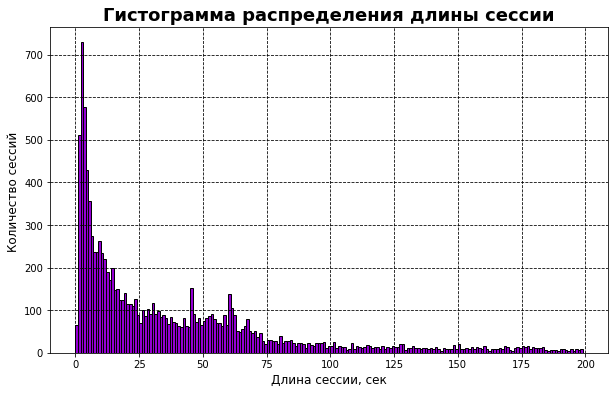

In [65]:
session_timespan = train_data_10users['session_timespan']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(session_timespan, color='darkviolet', edgecolor = 'black', bins=range(0,200))
plt.title('Гистограмма распределения длины сессии',fontsize = 18, fontweight = 'bold')
plt.xlabel('Длина сессии, сек', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

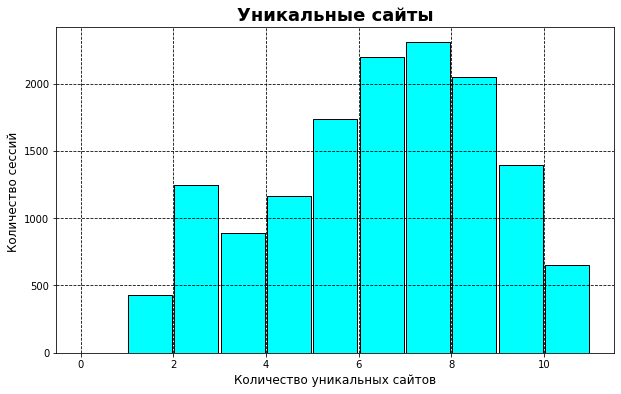

In [72]:
num_unique_sites = train_data_10users['unique_sites']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(num_unique_sites, color='aqua', edgecolor = 'black', bins=range(0, 12), rwidth = 0.95)
plt.title('Уникальные сайты',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество уникальных сайтов', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

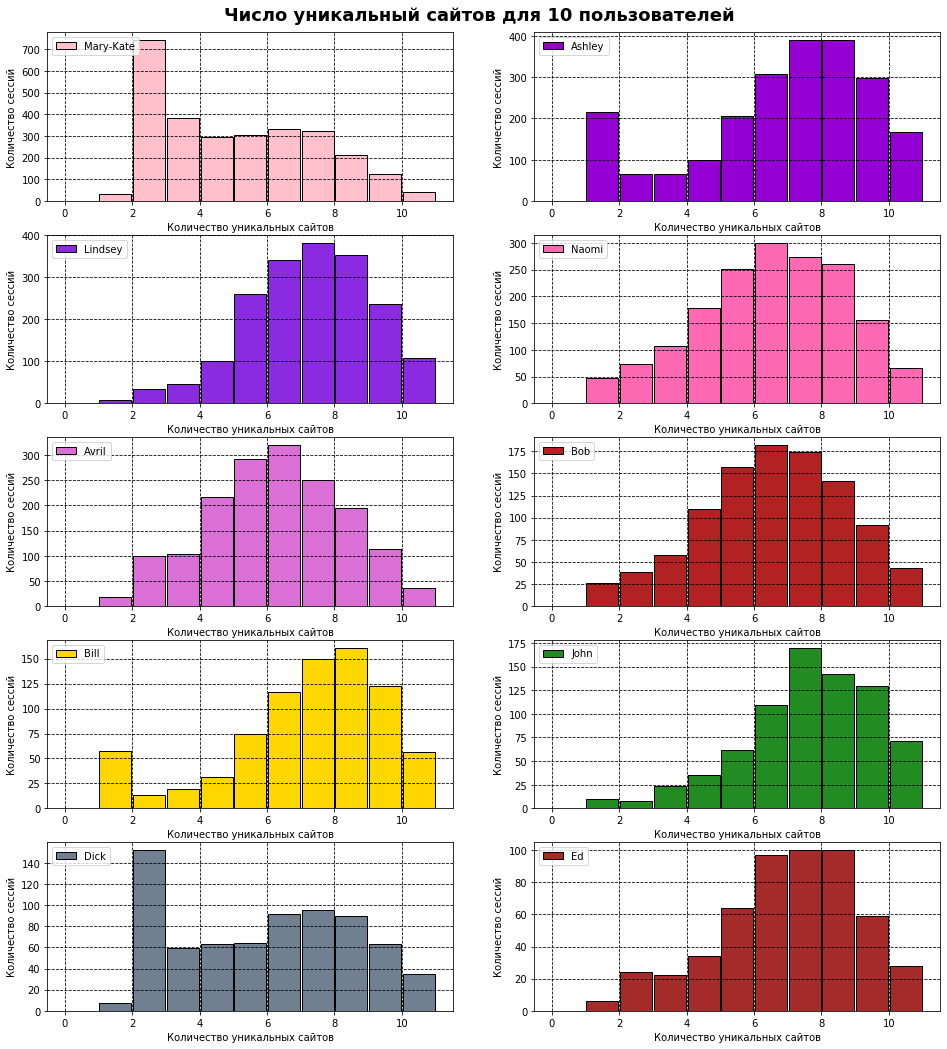

In [74]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
fig.suptitle('Число уникальный сайтов для 10 пользователей', fontsize = 18, fontweight = 'bold', y = 0.90)

idx=0
for name in id_name_dict:
    train_data_10users[(train_data_10users['user_id'] == id_name_dict[name])]['unique_sites'].plot(kind='hist', ax=axes[int(idx / 2), idx % 2], color=color_dic[id_name_dict[name]], edgecolor = 'black', legend=True, rwidth = 0.95, bins = range(0, 12))
    axes[int(idx/2), idx%2].set_xlabel('Количество уникальных сайтов')
    axes[int(idx/2), idx%2].set_ylabel('Количество сессий')
    axes[int(idx/2), idx%2].legend([id_name_dict[name]], loc='upper left')
    axes[int(idx/2), idx%2].grid(True)
    axes[int(idx/2), idx%2].grid(color='black', linestyle='--')
    idx+=1

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

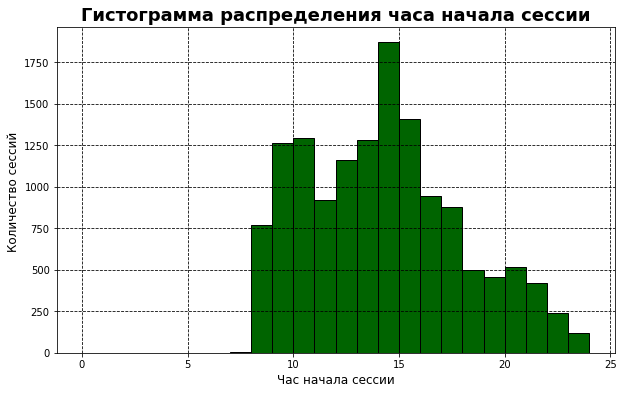

In [79]:
start_hour = train_data_10users['start_hour']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(start_hour, color='darkgreen', edgecolor = 'black', bins=range(0,25))
plt.title('Гистограмма распределения часа начала сессии',fontsize = 18, fontweight = 'bold')
plt.xlabel('Час начала сессии', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

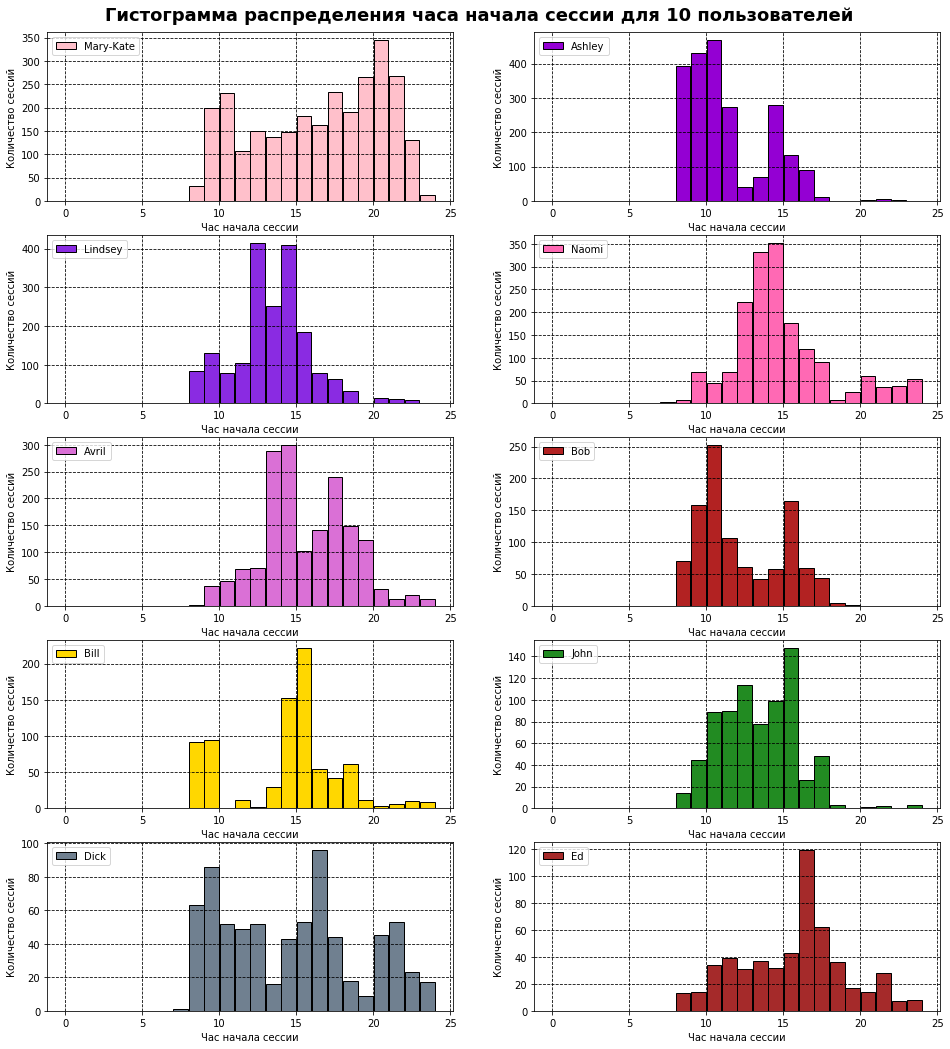

In [80]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
fig.suptitle('Гистограмма распределения часа начала сессии для 10 пользователей', fontsize = 18, fontweight = 'bold', y = 0.90)

idx=0
for name in id_name_dict:
    train_data_10users[(train_data_10users['user_id'] == id_name_dict[name])]['start_hour'].plot(kind='hist', ax=axes[int(idx / 2), idx % 2], color=color_dic[id_name_dict[name]], edgecolor = 'black', legend=True, rwidth = 0.95, bins = range(0, 25))
    axes[int(idx/2), idx%2].set_xlabel('Час начала сессии')
    axes[int(idx/2), idx%2].set_ylabel('Количество сессий')
    axes[int(idx/2), idx%2].legend([id_name_dict[name]], loc='upper left')
    axes[int(idx/2), idx%2].grid(True)
    axes[int(idx/2), idx%2].grid(color='black', linestyle='--')
    idx+=1

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

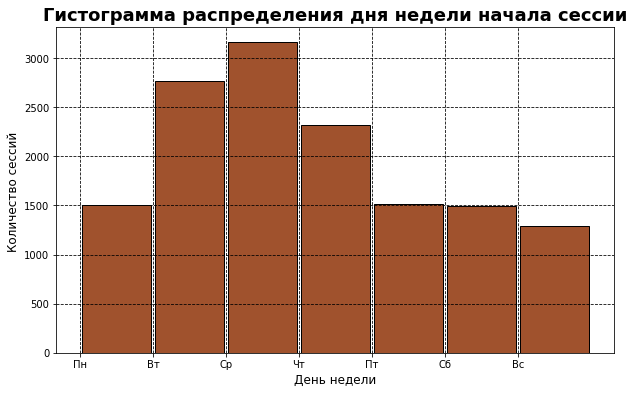

In [81]:
day_of_week = train_data_10users['day_of_week']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(day_of_week, color='sienna', edgecolor = 'black', bins=range(0, 8), rwidth = 0.95)
plt.title('Гистограмма распределения дня недели начала сессии',fontsize = 18, fontweight = 'bold')
plt.xlabel('День недели', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(0,7)),['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

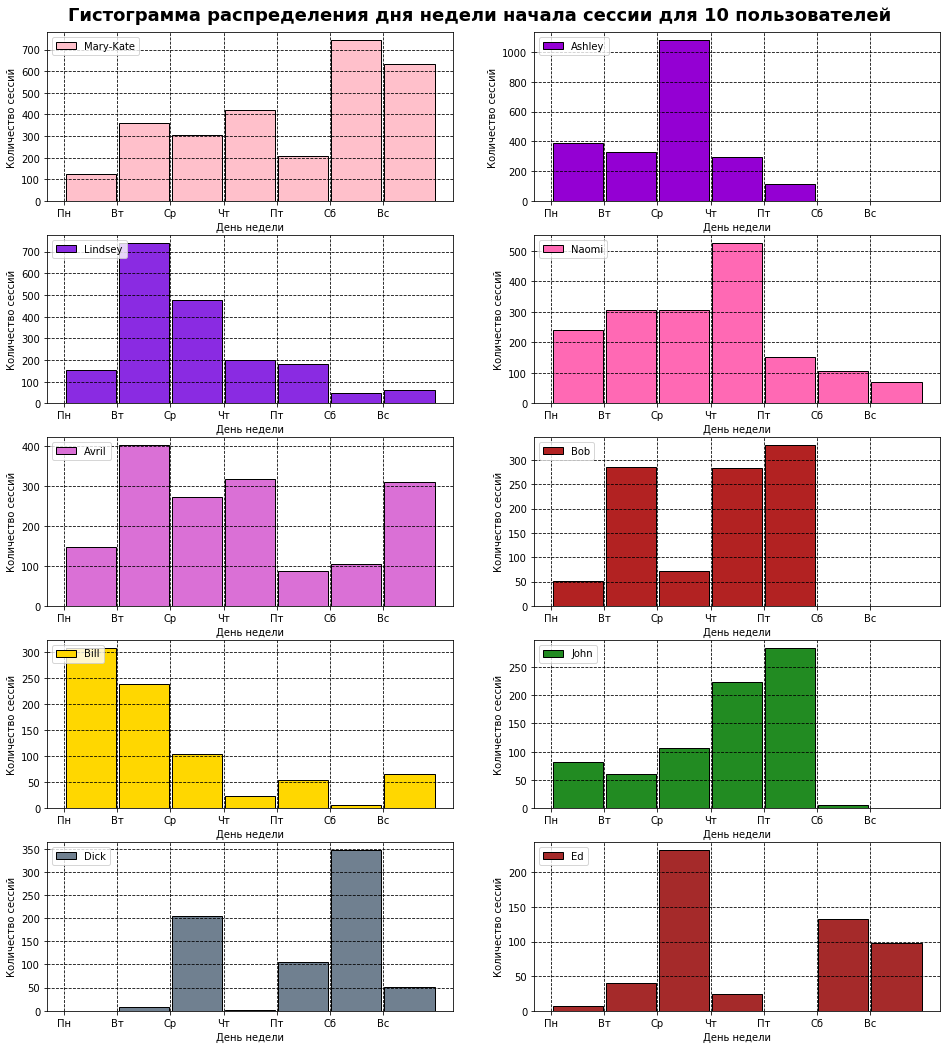

In [82]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
fig.suptitle('Гистограмма распределения дня недели начала сессии для 10 пользователей', fontsize = 18, fontweight = 'bold', y = 0.90)

idx=0
for name in id_name_dict:
    train_data_10users[(train_data_10users['user_id'] == id_name_dict[name])]['day_of_week'].plot(kind='hist', ax=axes[int(idx / 2), idx % 2], color=color_dic[id_name_dict[name]], edgecolor = 'black', legend=True, rwidth = 0.95, bins = range(0, 8))
    axes[int(idx/2), idx%2].set_xlabel('День недели')
    axes[int(idx/2), idx%2].set_ylabel('Количество сессий')
    axes[int(idx/2), idx%2].legend([id_name_dict[name]], loc='upper left')
    axes[int(idx/2), idx%2].grid(True)
    axes[int(idx/2), idx%2].grid(color='black', linestyle='--')
    axes[int(idx/2), idx%2].set_xticks(range(0, 7))
    axes[int(idx/2), idx%2].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    idx+=1

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. Mary-Kate: Пики активности приходятся на выходные дни, в будние дни тоже серфит интернет, но реже. В основном предпочитает заходить в интернет вечером. Посещает какие-то конкретные сайты (1-2 за сессию).
2. Ashley: Чаще всего заходит в интернет по средам, в выходные дни в нем не появляется вообще. Пики активности приходятся на утренние часы, вечером в интернет не заходит. Любит блуждать по страничкам, но иногда сидит на каком-то конкретном сайте.
3. Lindsey: Чаще всего сидит в интернете по вторникам и средам в обеденные часы. Заходит на разные сайты.
4. Naomi: Пик активности приходится на четверг, с понедельника по среду сидит в интернете умеренно, в остальные дни заходит редко. Предпочитает проводить обеденное время в интернете, посещая разные сайты.
5. Avril: Предпочитает сидеть в интернете со вторника по четверг и в воскресенье. Во вторник особенно активно. Заходит в обед и вечером. Посещает разные сайты.
6. Bob: Во вторник, четверг и пятницу особенно активен в сети, в выходные там не появляется. Заходит с утра и после обеда. Посещает разные сайты.
7. Bill: Чаще всего заходит в интернет в понедельник и вторник рано утром и днем. Посещает разные сайты.
8. John: Чаще всего заходит в интернет в четверг и пятницу утром и днем. Посещает разные сайты.
9. Dick: Сидит в интернете в основном в субботу и среду. Заходит и утром, и днем и вечером. Чаще всего время в сети предпочитает проводить на одном-двух сайтах.
10. Ed: Пик активности приходится на среду, по субботам и воскресеньям тоже частенько заходит в интернет. В основновном заходит в интернет днем. Посещает разные сайты.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [38]:
with open(os.path.join(PATH_TO_DATA,'week1/files/site_freq_10users.pkl'), 'rb') as fp:
    frequency_dict = pickle.load(fp)

In [53]:
for key in frequency_dict:
    if 'facebook' in key:
        print(frequency_dict[key][0])

5
17
18
45
275
309
565
568
630
1006
1610
1799
1817
2053
2324
2389
4108


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [86]:
top10_freqs = pd.DataFrame.from_dict(frequency_dict, orient='index', 
                                     columns=['num', 'freq']).iloc[:10, :].freq.values
top10_sites = pd.DataFrame.from_dict(frequency_dict, orient='index', 
                                     columns=['num', 'freq']).iloc[:10, :].index.values

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

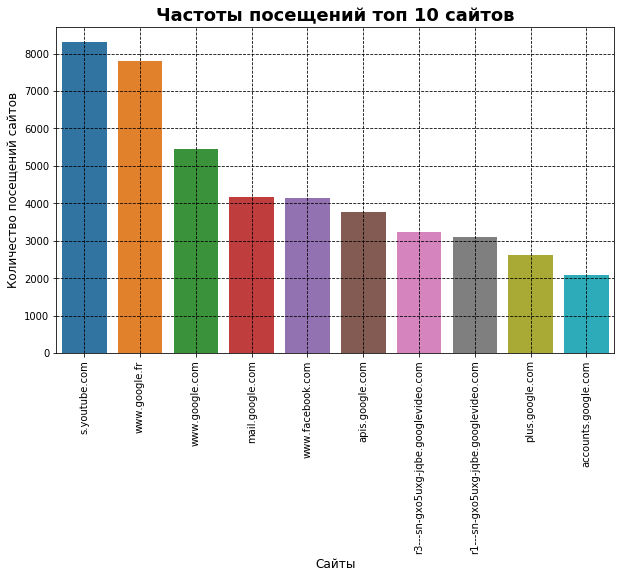

In [88]:
plt.figure(figsize = (10, 6))
sns.barplot(top10_sites, top10_freqs)
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.xticks(rotation=90)
plt.title('Частоты посещений топ 10 сайтов',fontsize = 18, fontweight = 'bold')
plt.xlabel('Сайты', fontsize = 12)
plt.ylabel('Количество посещений сайтов', fontsize = 12)
plt.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

Итак, попробуем добавить такие признаки, как:  
 1. месяц начала сессии;
 2. время суток
 3. количество посещений facebook за сессию
 4. количество посещений youtube за сессию
 5. количество посещений google за сессию

In [155]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10):

    csv_files = glob(path_to_csv_files + '/*.csv')
    csv_files.sort()
    all_sites = []
    timestamp = []
    all_time_delta_session = []
    start_session = []
    day_of_week = []
    uniq_values = []
    months = []
    
    #открытие уже ранее созданного частотного словаря    
    with open(site_freq_path, 'rb') as fp:
        frequency_dict = pickle.load(fp)
        
    #добавление сайтов и даты их посещения в списки
    for file in tqdm_notebook(csv_files):
        data = pd.read_csv(file, engine = 'python')
        all_sites.append(data['site'])
        timestamp.append(data['timestamp'])

        #подсчет продолжительности сессии, начала сессии и дня недели  
        time_session = pd.to_datetime(data['timestamp'])
        for i in range(0, len(time_session), session_length):
            if (i + session_length) < len(time_session):
                time_delta_session = datetime.strptime(str(time_session[i + session_length - 1]), '%Y-%m-%d %H:%M:%S') - datetime.strptime(str(time_session[i]), '%Y-%m-%d %H:%M:%S')
                all_time_delta_session.append(time_delta_session.seconds)
                start_session.append(datetime.strptime(str(time_session[i]), '%Y-%m-%d %H:%M:%S').hour)
                day_of_week.append(time_session.dt.dayofweek[i])
                #добавление нового признака: месяц начала сессии
                months.append(time_session.dt.month[i])
            else:
                time_delta_session = datetime.strptime(str(max(time_session)), '%Y-%m-%d %H:%M:%S')- datetime.strptime(str(time_session[i]), '%Y-%m-%d %H:%M:%S')
                all_time_delta_session.append(time_delta_session.seconds)
                start_session.append(datetime.strptime(str(time_session[i]), '%Y-%m-%d %H:%M:%S').hour)
                day_of_week.append(time_session.dt.dayofweek[i])
                months.append(time_session.dt.month[i])

    #добавление нового признака: время суток
    times_of_day = []
    for hour in start_session:
        if hour >= 6 and hour <= 9:
            times_of_day.append(1)
        elif hour > 9 and hour <= 12:
            times_of_day.append(2)
        elif hour > 12 and hour <= 15:
            times_of_day.append(3)
        elif hour > 15 and hour <= 18:
            times_of_day.append(4)
        elif hour > 18 and hour <= 22:
            times_of_day.append(5)
        else:
            times_of_day.append(6)
    
    #создание списка с id пользователей 
    user_id = []
    for i in csv_files:
        file_name, _ = splitext(basename(i))
        file_name = re.sub('^0*', '', file_name[4:])
        user_id.append(int(file_name))   

    columns_sites = ['site' + str(i) for i in range(1, session_length + 1)]
    columns_times = ['diff_time' + str(i) for i in range(1, session_length + 1)]

    features_sites = []
    features_times = []
    
    #формирование сессий по каждому пользователю в зависимости от длины сессии(session_length) и ширины окна(window_size)
    for index, (times, sites) in enumerate(zip(timestamp, all_sites)):
        times_number = times.shape[0]
        rows = math.ceil(times_number / window_size)
        length = rows * session_length
        sessions_times = np.empty(length, dtype=object)
        sessions_sites = np.empty(length, dtype=int)
        zeros = length - times_number
        sessions_id = np.empty(length, dtype=int)

        if zeros > 0:
            sessions_times[-zeros:] = 0
            sessions_sites[-zeros:] = 0

        #формирование таблицы c индексами сайтов, посещенными пользователеми
        for i, site in enumerate(sites):
            sessions_sites[i] = frequency_dict[site][0]
        sessions_sites = np.reshape(sessions_sites, (rows, -1))
        sessions_sites = np.array(list(mit.windowed(sessions_sites.ravel(), n=session_length, step=window_size)))

        #подсчет уникальных значений
        for i in sessions_sites:
            if 0 in i:
                uniq_values.append(len(np.unique(i)) - 1)
            else:
                uniq_values.append(len(np.unique(i)))

        data_sites = pd.DataFrame(sessions_sites, columns=columns_sites)
        features_sites.append(data_sites)

        #формирование таблицы c продолжительностью посещения каждого сайта в секундах
        for i, time in enumerate(times):
            if i < (len(times) - 1):
                time_delta = (datetime.strptime(str(times[i+1]), '%Y-%m-%d %H:%M:%S') - datetime.strptime(str(times[i]), '%Y-%m-%d %H:%M:%S')).seconds
            sessions_times[i] = time_delta
        sessions_times = np.reshape(sessions_times, (rows, -1))
        sessions_times = np.array(list(mit.windowed(sessions_times.ravel(), n=session_length, step=window_size)))
        data_times = pd.DataFrame(sessions_times, columns=columns_times)  
        features_times.append(data_times)
        data_times['user_id'] = user_id[index]

    features_sites = features_sites[0].append(features_sites[1:])
    features_times = features_times[0].append(features_times[1:])

    data = pd.concat([features_sites, features_times], axis=1)
    data = data.fillna(0)
    data = data[(data.site1 > 0)]

    #добавление признаков: продолжение сессии в секундах, час начала сессии, день недели начала сессии, число уникальных сайтов в сессии
    data['session_timespan'] = all_time_delta_session
    data['start_hour'] = start_session
    data['day_of_week'] = day_of_week
    data['unique_sites'] = uniq_values
    data['start_month'] = months
    data['time_of_day'] = times_of_day
    data['fb_visit'] = (data.iloc[:, :session_length].isin([frequency_dict[key][0] for key in frequency_dict if 'facebook' in key])).sum(1)
    data['youtube_visit'] = (data.iloc[:, :session_length].isin([frequency_dict[key][0] for key in frequency_dict if 'youtube' in key])).sum(1)
    data['google_visit'] = (data.iloc[:, :session_length].isin([frequency_dict[key][0] for key in frequency_dict if 'google' in key])).sum(1)
    
    return data


In [156]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         'data/10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'week1/files/site_freq_10users.pkl'),
                  session_length=10, window_size=10)


CPU times: user 1min, sys: 8 ms, total: 1min
Wall time: 1min


In [171]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         'data/150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'week1/files/site_freq_150users.pkl'),
                  session_length=10, window_size=10)


CPU times: user 7min 19s, sys: 172 ms, total: 7min 19s
Wall time: 7min 21s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [157]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,diff_time1,diff_time2,...,diff_time9,diff_time10,user_id,session_timespan,start_hour,day_of_week,unique_sites,start_month,time_of_day,fb_visit,youtube_visit,google_visit
0,193,574,133,3,133,133,3,133,203,133,10,0,...,0,0,31,33,8,4,5,11,1,0,0,2
1,422,192,681,257,133,31,398,4223,217,55,1,0,...,8,1,31,284,8,4,10,11,1,0,0,1
2,55,3,55,55,5,293,422,341,910,55,0,14,...,0,0,31,258,8,4,7,11,1,1,0,1
3,476,4196,476,55,55,55,55,958,200,124,2,1,...,0,0,31,30,8,4,6,11,1,0,0,0
4,346,55,5,4668,258,211,4422,2286,700,2286,1,0,...,0,1,31,6,8,4,9,11,1,1,0,0


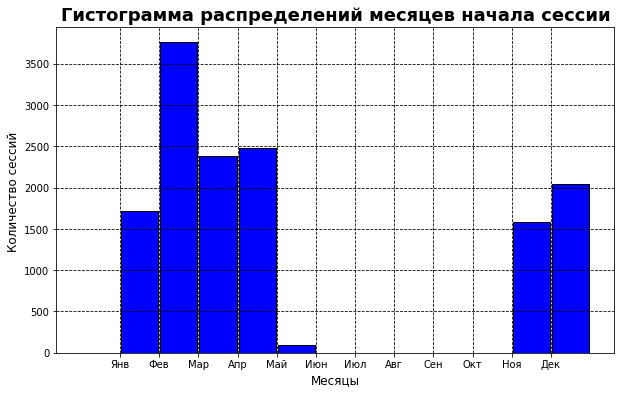

In [169]:
start_month = new_features_10users['start_month']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(start_month, color='blue', edgecolor = 'black', bins=range(0, 14), rwidth = 0.95)
plt.title('Гистограмма распределений месяцев начала сессии',fontsize = 18, fontweight = 'bold')
plt.xlabel('Месяцы', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(1,13)),['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.show()

Как мы видим на графике, активность пользователей в сети приходится на холодное время года. Но мы не можем быть в этом полностью уверены, поскольку данные за лето и начало осени отсутствуют совсем. Построим гистограммы по каждому пользователю.

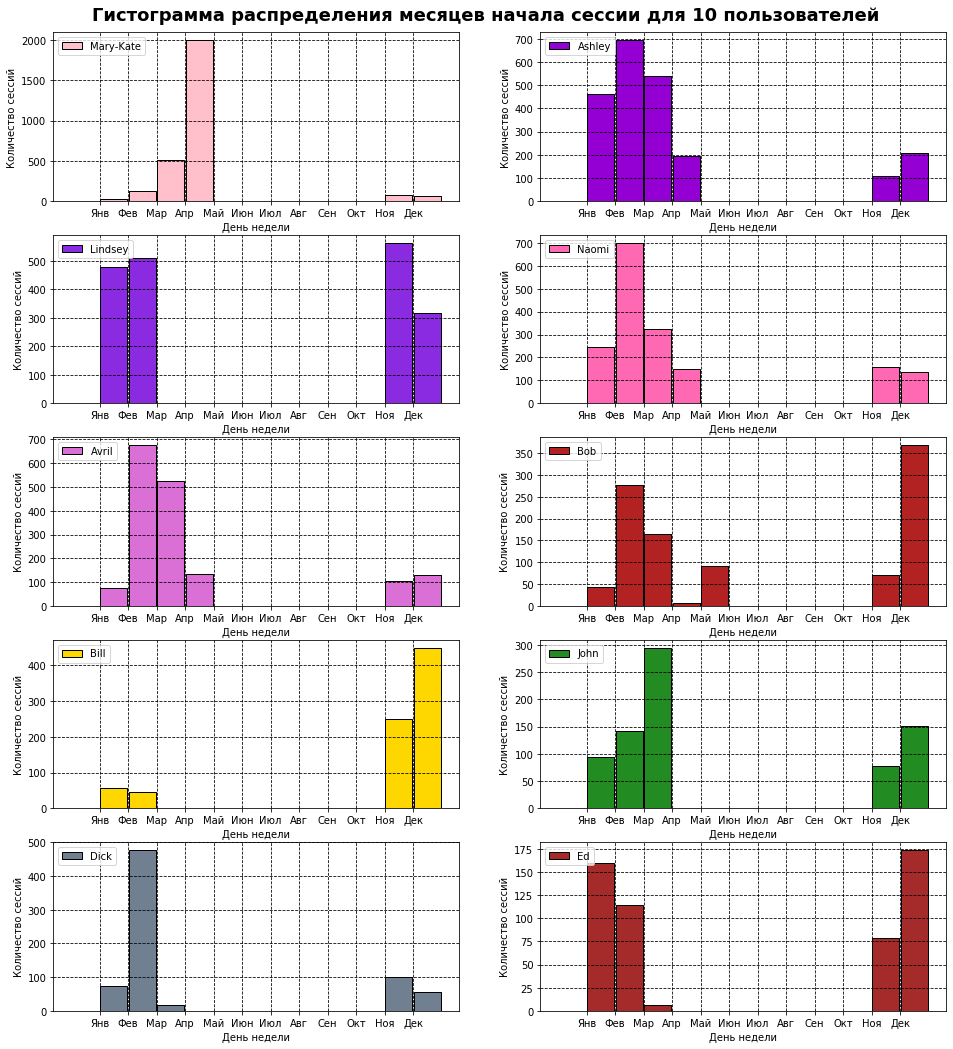

In [166]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
fig.suptitle('Гистограмма распределения месяцев начала сессии для 10 пользователей', fontsize = 18, fontweight = 'bold', y = 0.90)

idx=0
for name in id_name_dict:
    new_features_10users[(train_data_10users['user_id'] == id_name_dict[name])]['start_month'].plot(kind='hist', ax=axes[int(idx / 2), idx % 2], color=color_dic[id_name_dict[name]], edgecolor = 'black', legend=True, rwidth = 0.95, bins = range(0, 14))
    axes[int(idx/2), idx%2].set_xlabel('День недели')
    axes[int(idx/2), idx%2].set_ylabel('Количество сессий')
    axes[int(idx/2), idx%2].legend([id_name_dict[name]], loc='upper left')
    axes[int(idx/2), idx%2].grid(True)
    axes[int(idx/2), idx%2].grid(color='black', linestyle='--')
    axes[int(idx/2), idx%2].set_xticks(range(1, 13))
    axes[int(idx/2), idx%2].set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
    idx+=1

Как мы видим, гистограммы пользователей отличаются друг от друга. Можем попробовать использовать этот признак для идентификации пользователя. Рассмотрим следующий признак: время суток

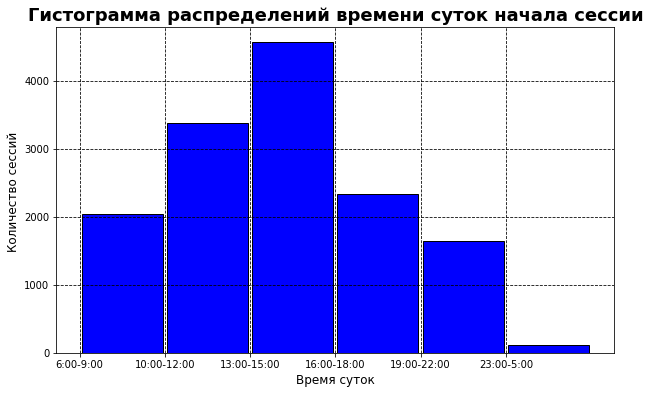

In [189]:
time_of_day = new_features_10users['time_of_day']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(time_of_day, color='blue', edgecolor = 'black', bins=range(1, 8), rwidth = 0.95)
plt.title('Гистограмма распределений времени суток начала сессии',fontsize = 18, fontweight = 'bold')
plt.xlabel('Время суток', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.xticks(list(range(1,7)),['6:00-9:00', '10:00-12:00', '13:00-15:00', '16:00-18:00', '19:00-22:00', '23:00-5:00'])
plt.show()

Видим, пользователи чаще всего активны в рабочее время(с 10:00 до 19:00), но пик активности приходится на обеденное время(с 12:00 до 15:00). Теперь посмотрим на распределения конкретных 10 пользователей.

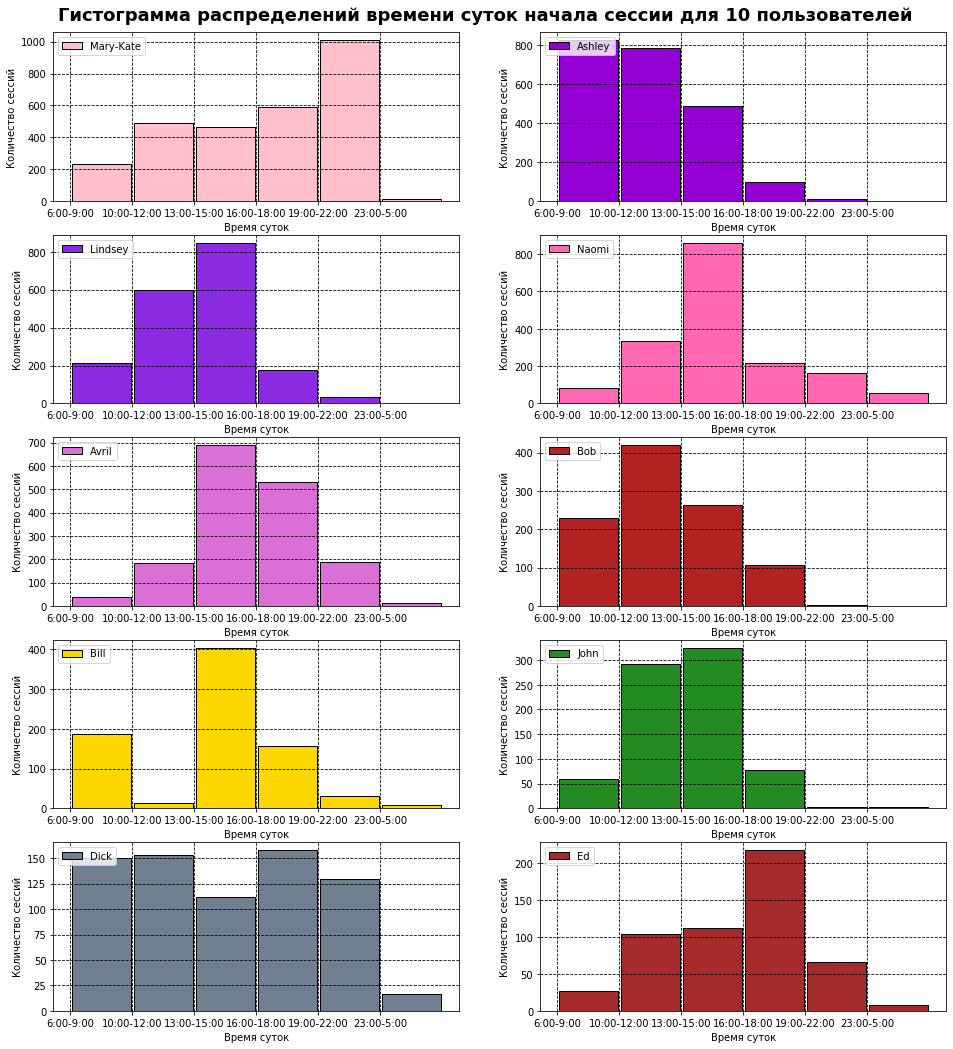

In [190]:
new_features_10users.time_of_day = pd.to_numeric(new_features_10users.time_of_day, errors='ignore')
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
fig.suptitle('Гистограмма распределений времени суток начала сессии для 10 пользователей', fontsize = 18, fontweight = 'bold', y = 0.90)

idx=0
for name in id_name_dict:
    new_features_10users[(train_data_10users['user_id'] == id_name_dict[name])]['time_of_day'].plot(kind='hist', ax=axes[int(idx / 2), idx % 2], color=color_dic[id_name_dict[name]], edgecolor = 'black', legend=True, rwidth = 0.95, bins = range(1, 8))
    axes[int(idx/2), idx%2].set_xlabel('Время суток')
    axes[int(idx/2), idx%2].set_ylabel('Количество сессий')
    axes[int(idx/2), idx%2].legend([id_name_dict[name]], loc='upper left')
    axes[int(idx/2), idx%2].grid(True)
    axes[int(idx/2), idx%2].grid(color='black', linestyle='--')
    axes[int(idx/2), idx%2].set_xticks(range(1, 7))
    axes[int(idx/2), idx%2].set_xticklabels(['6:00-9:00', '10:00-12:00', '13:00-15:00', '16:00-18:00', '19:00-22:00', '23:00-5:00'])
    idx+=1

Видим, что активность пребывания в интернете у пользователей разная. Допустим, Naomi большую часть времени в интернете проводит с 13:00 до 15:00, а вот, например, Dick активен с утра до вечера. Думаю, этот признак сможет помочь идентифицировать конкретного пользователя.

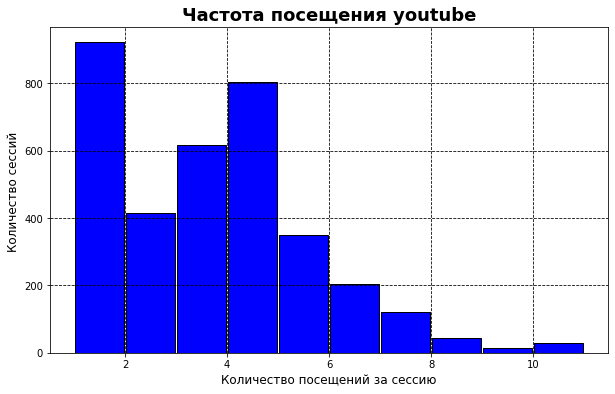

In [158]:
yt_visits = new_features_10users['youtube_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(yt_visits, color='blue', edgecolor = 'black', bins=range(1, 12), rwidth = 0.95)
plt.title('Частота посещения youtube',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

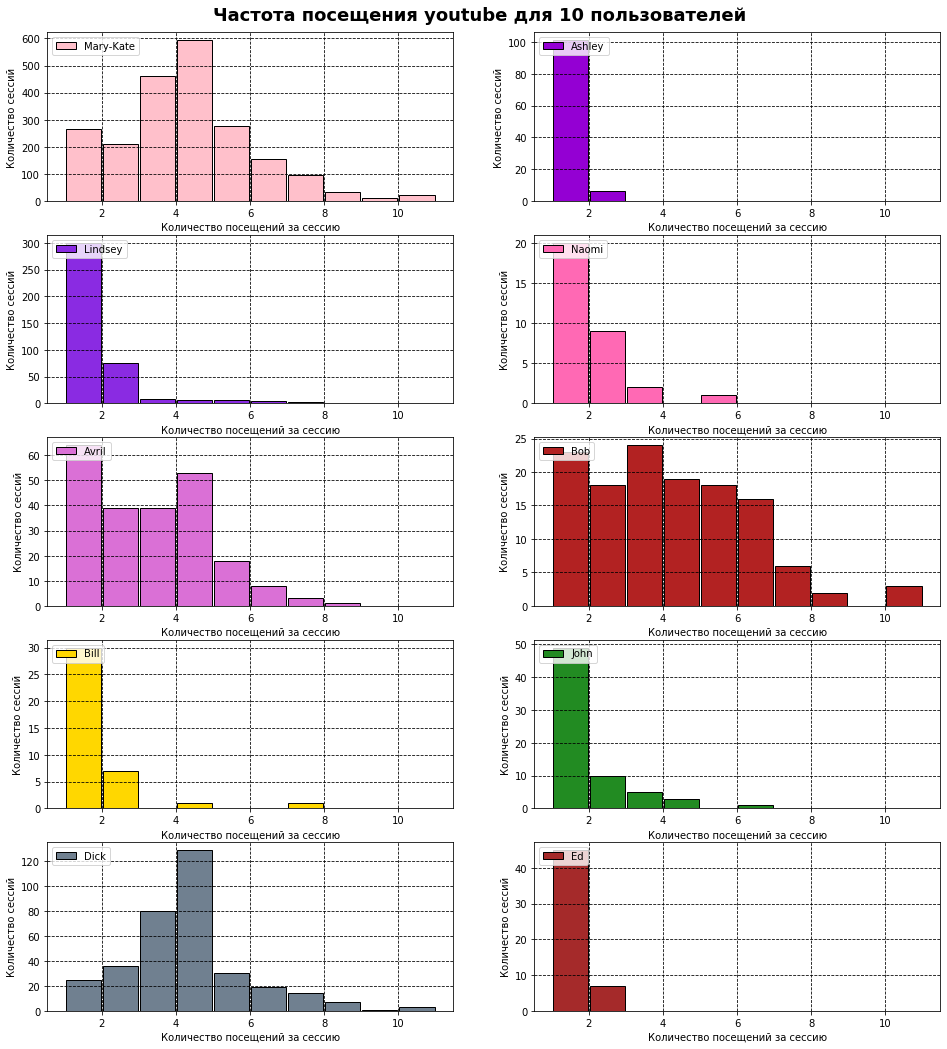

In [159]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
fig.suptitle('Частота посещения youtube для 10 пользователей', fontsize = 18, fontweight = 'bold', y = 0.90)

idx=0
for name in id_name_dict:
    new_features_10users[(train_data_10users['user_id'] == id_name_dict[name])]['youtube_visit'].plot(kind='hist', ax=axes[int(idx / 2), idx % 2], color=color_dic[id_name_dict[name]], edgecolor = 'black', legend=True, rwidth = 0.95, bins = range(1, 12))
    axes[int(idx/2), idx%2].set_xlabel('Количество посещений за сессию')
    axes[int(idx/2), idx%2].set_ylabel('Количество сессий')
    axes[int(idx/2), idx%2].legend([id_name_dict[name]], loc='upper left')
    axes[int(idx/2), idx%2].grid(True)
    axes[int(idx/2), idx%2].grid(color='black', linestyle='--')
    idx+=1

Видим, что кто-то из пользователей являетя завсегдатаем данного сервиса, а кто-то заходит туда время от времени. 

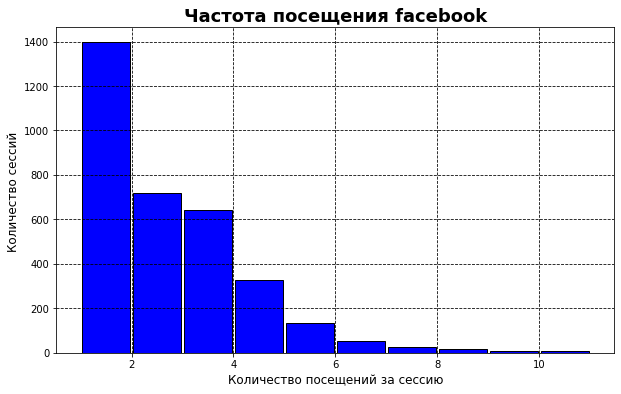

In [160]:
fb_visits = new_features_10users['fb_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(fb_visits, color='blue', edgecolor = 'black', bins=range(1, 12), rwidth = 0.95)
plt.title('Частота посещения facebook',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

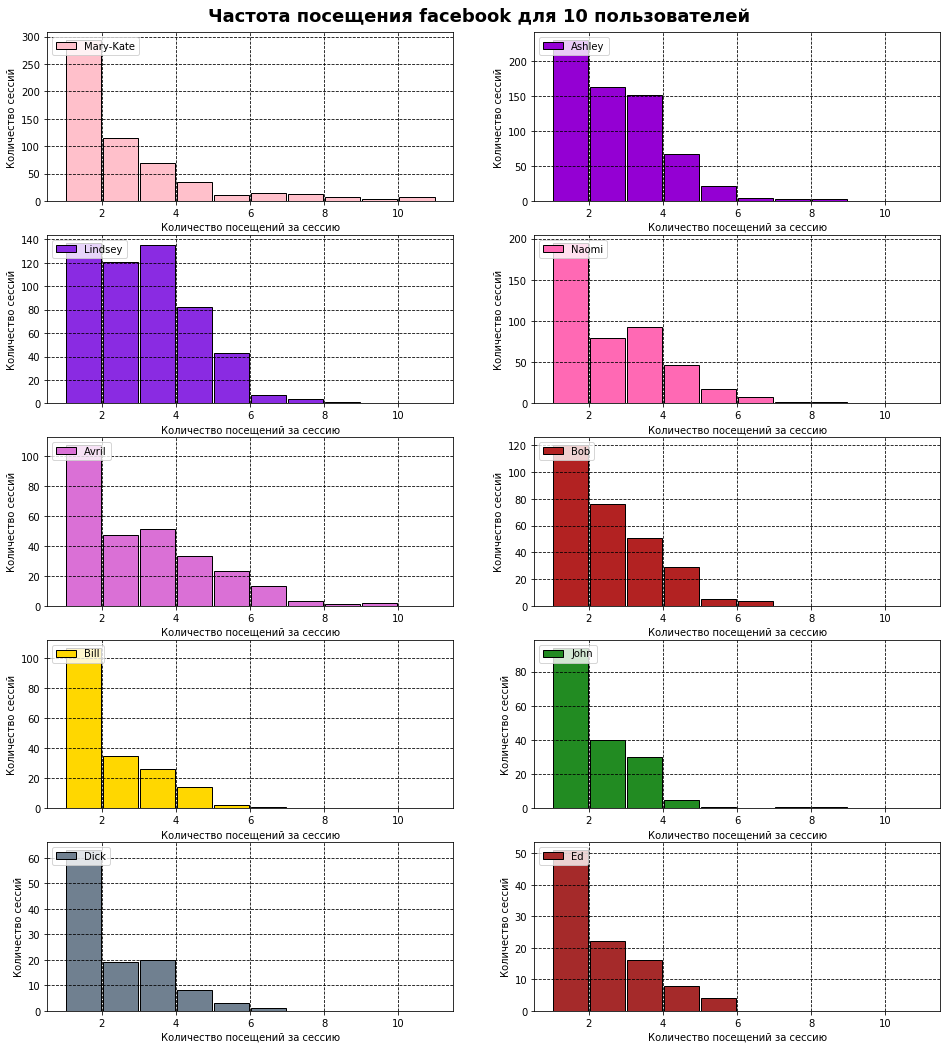

In [161]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
fig.suptitle('Частота посещения facebook для 10 пользователей', fontsize = 18, fontweight = 'bold', y = 0.90)

idx=0
for name in id_name_dict:
    new_features_10users[(train_data_10users['user_id'] == id_name_dict[name])]['fb_visit'].plot(kind='hist', ax=axes[int(idx / 2), idx % 2], color=color_dic[id_name_dict[name]], edgecolor = 'black', legend=True, rwidth = 0.95, bins = range(1, 12))
    axes[int(idx/2), idx%2].set_xlabel('Количество посещений за сессию')
    axes[int(idx/2), idx%2].set_ylabel('Количество сессий')
    axes[int(idx/2), idx%2].legend([id_name_dict[name]], loc='upper left')
    axes[int(idx/2), idx%2].grid(True)
    axes[int(idx/2), idx%2].grid(color='black', linestyle='--')
    idx+=1

Видим, что гистограммы отдельных пользователей в целом похожи друг на друга и повторяют общее распределение.

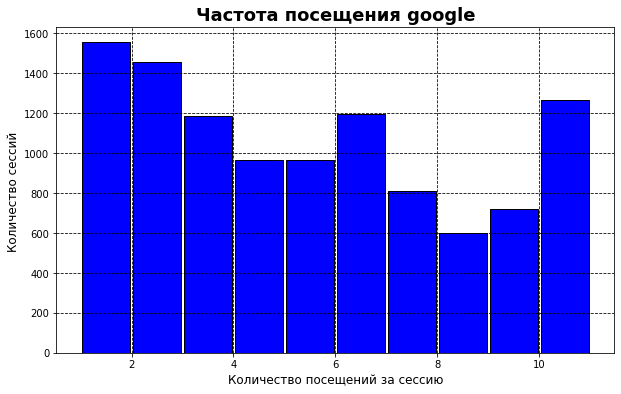

In [162]:
g_visits = new_features_10users['google_visit']
plt.figure(figsize = (10, 6))
plt.grid(True)
plt.grid(color = 'black', linestyle = '--')
plt.hist(g_visits, color='blue', edgecolor = 'black', bins=range(1, 12), rwidth = 0.95)
plt.title('Частота посещения google',fontsize = 18, fontweight = 'bold')
plt.xlabel('Количество посещений за сессию', fontsize = 12)
plt.ylabel('Количество сессий ', fontsize = 12)
plt.show()

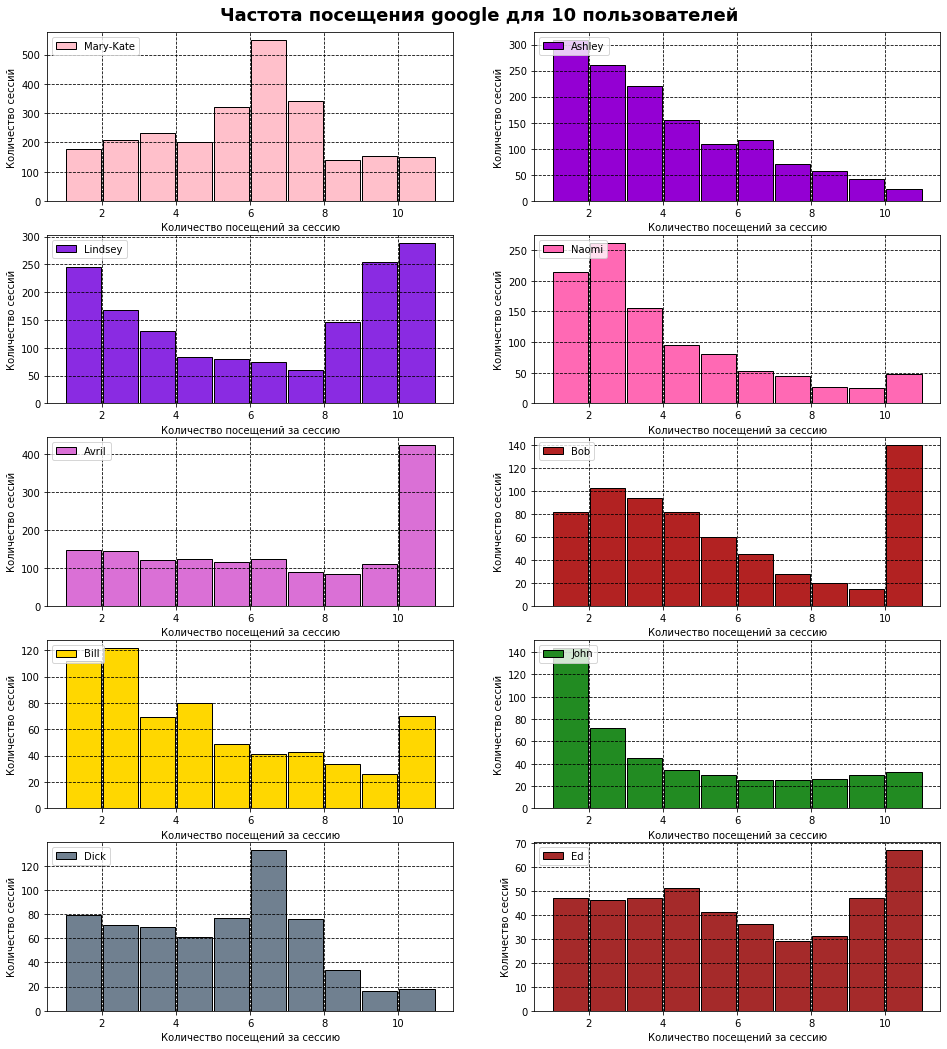

In [163]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
fig.suptitle('Частота посещения google для 10 пользователей', fontsize = 18, fontweight = 'bold', y = 0.90)

idx=0
for name in id_name_dict:
    new_features_10users[(train_data_10users['user_id'] == id_name_dict[name])]['google_visit'].plot(kind='hist', ax=axes[int(idx / 2), idx % 2], color=color_dic[id_name_dict[name]], edgecolor = 'black', legend=True, rwidth = 0.95, bins = range(1, 12))
    axes[int(idx/2), idx%2].set_xlabel('Количество посещений за сессию')
    axes[int(idx/2), idx%2].set_ylabel('Количество сессий')
    axes[int(idx/2), idx%2].legend([id_name_dict[name]], loc='upper left')
    axes[int(idx/2), idx%2].grid(True)
    axes[int(idx/2), idx%2].grid(color='black', linestyle='--')
    idx+=1

Заметно, что google самый популярный сервис у наших пользователей. Встречаются пользователи(Lindsey, Avril, Bob, Ed), у которых количество посещений google за сессию достигает 10, что означает, что на протяжении всей сессии они находятся на данном сервисе. 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [183]:
selected_features_10users = new_features_10users[['start_month', 'time_of_day', 'youtube_visit', 'google_visit']]
selected_features_150users = new_features_150users[['start_month', 'time_of_day', 'youtube_visit', 'google_visit']]

In [184]:
with open(os.path.join(PATH_TO_DATA, 
                       'week3/files/selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'week3/files/selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 